### Imports

In [20]:
import pandas as pd
import json
import numpy as np
import tensorflow

import warnings
warnings.filterwarnings(action="ignore")

### Connect to drive and load data

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dir_path = "drive/MyDrive/data_ids_challenge"

df_data = pd.read_csv(f"{dir_path}/ML-EdgeIIoT-dataset-processed.csv", index_col=0)
df_label = pd.read_csv(f"{dir_path}/ML-EdgeIIoT-dataset-labels.csv", index_col=0)

## Split the data to train and test

In [7]:
for col in ['Attack_type']:
    df_label[col], _ = pd.factorize(df_label[col])

In [8]:
from sklearn.model_selection import train_test_split

#### Multiclass classification

In this notebook I will focuse only on the multiclass problem

In [9]:
X_train_full, X_test, y_train_full, y_test = train_test_split(df_data, df_label['Attack_type'], random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

Preprocess the labels for the DNN model

In [10]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [11]:
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_valid_encoded = encoder.transform(np.array(y_valid).reshape(-1, 1))
y_test_encoded = encoder.transform(np.array(y_test).reshape(-1, 1))

### DNN

Let's start with a simple DNN model with three layers - the first two will be densed and the last one will be the ouput layer and we will work from there

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import os

The architecture below is very simple, and I am using basic paremeters that we will later tweek and improve.

categorical_crossentropy is used as it is a loss function suited for our needs and softmax is used to give us the probability to be associated to each class

In [ ]:
model = Sequential()
model.add(Dense(64, activation="relu", kernel_initializer=HeNormal()))
model.add(Dense(32, activation="relu", kernel_initializer=HeNormal()))
model.add(Dense(15, activation="softmax", kernel_initializer=HeNormal()))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Define the checkpoint filepath
filepath = "/content/drive/MyDrive/model_checkpoints_DNN/checkpoint-{epoch:02d}.keras"

if not os.path.exists("/content/drive/MyDrive/model_checkpoints_DNN/"):
    os.mkdir("/content/drive/MyDrive/model_checkpoints_DNN/")

# Define the callback
checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
)

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train_encoded, epochs=50,
                    validation_data=(X_valid, y_valid_encoded),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
2774/2774 [==============================] - 7s 2ms/step - loss: 1.1042 - accuracy: 0.6296 - val_loss: 0.8529 - val_accuracy: 0.6961
Epoch 2/50
2774/2774 [==============================] - 9s 3ms/step - loss: 0.7580 - accuracy: 0.7312 - val_loss: 0.6715 - val_accuracy: 0.7514
Epoch 3/50
2774/2774 [==============================] - 6s 2ms/step - loss: 0.6143 - accuracy: 0.7823 - val_loss: 0.5598 - val_accuracy: 0.7931
Epoch 4/50
2774/2774 [==============================] - 8s 3ms/step - loss: 0.5187 - accuracy: 0.8175 - val_loss: 0.4756 - val_accuracy: 0.8199
Epoch 5/50
2774/2774 [==============================] - 8s 3ms/step - loss: 0.4637 - accuracy: 0.8334 - val_loss: 0.4400 - val_accuracy: 0.8282
Epoch 6/50
2774/2774 [==============================] - 8s 3ms/step - loss: 0.4314 - accuracy: 0.8418 - val_loss: 0.4154 - val_accuracy: 0.8493
Epoch 7/50
2774/2774 [==============================] - 8s 3ms/step - loss: 0.4115 - accuracy: 0.8459 - val_loss: 0.4031 - val_accuracy:

The validation data accuracy reaches at max 0.8791 (remember that maybe the accuracy is not the most perfect metric).
The loos goes down to 0.3002.

As a conclusion for a first test run is that the model converges nicely to a good score but well below RandomForest

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
def create_model(optimizer="adam", num_layers=2, neurons_per_layer=64, activation='relu', initializer=HeNormal()):
    model = Sequential()
    model.add(Dense(neurons_per_layer, activation=activation, kernel_initializer=initializer, input_shape=X_train.iloc[0].shape))
    for _ in range(num_layers - 1):
        model.add(Dense(neurons_per_layer, activation=activation, kernel_initializer=initializer))
    model.add(Dense(15, activation="softmax", kernel_initializer=initializer))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_wrapper = KerasClassifier(model=create_model, epochs=10,
                                initializer=HeNormal(), num_layers=2, neurons_per_layer=16,
                                optimizer=Adam(learning_rate=0.001))

param_grid = {
    'optimizer': ["adam", SGD(learning_rate=0.01), RMSprop(learning_rate=0.01)],
    'num_layers': [2, 3],
    'neurons_per_layer': [16, 32, 64],
    'initializer': ['HeNormal', 'glorot_uniform'],
}

grid_search = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(X_train, y_train_encoded, validation_data=(X_valid, y_valid_encoded))

Epoch 1/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.3784 - loss: 1.9081 - val_accuracy: 0.6330 - val_loss: 1.1674
Epoch 2/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6511 - loss: 1.1084 - val_accuracy: 0.6808 - val_loss: 0.9778
Epoch 3/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6897 - loss: 0.9614 - val_accuracy: 0.6990 - val_loss: 0.9031
Epoch 4/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6972 - loss: 0.8939 - val_accuracy: 0.7056 - val_loss: 0.8600
Epoch 5/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7046 - loss: 0.8493 - val_accuracy: 0.7146 - val_loss: 0.8157
Epoch 6/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7101 - loss: 0.8191 - val_accuracy: 0.7178 - val_loss: 0.7928
Epoch 7/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7176 - loss: 0.7893 - val_accuracy: 0.7278 - val_loss: 0.7726
Epoch 8/10
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7279 - loss: 0.7538 -

In [ ]:
print(f"Best params: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")

Best params: {'initializer': 'HeNormal', 'neurons_per_layer': 64, 'num_layers': 3, 'optimizer': <keras.src.optimizers.sgd.SGD object at 0x79adb5ae77f0>}
Best score: 0.8691106829697747


Now we will train the model with the best params found

In [14]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from imblearn.over_sampling import SMOTE

In [15]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [19]:
smote = SMOTE(k_neighbors=5, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
X_valid_resampled, y_valid_reseampled = smote.fit_resample(X_valid, y_valid_encoded)

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

In [17]:
model = Sequential()
model.add(Dense(64, activation="relu", kernel_initializer=HeNormal()))
model.add(Dense(64, activation="relu", kernel_initializer=HeNormal()))
model.add(Dense(64, activation="relu", kernel_initializer=HeNormal()))
model.add(Dense(15, activation="softmax", kernel_initializer=HeNormal()))
model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
train_history = model.fit(X_train, y_train_encoded, epochs=100,
                    validation_data=(X_valid, y_valid_encoded),
                    callbacks=[checkpoint, early_stopping, reduce_lr],
                    class_weight=class_weights_dict)

Epoch 1/100
2774/2774 [==============================] - 9s 3ms/step - loss: 0.6667 - accuracy: 0.7482 - val_loss: 0.6621 - val_accuracy: 0.7647 - lr: 0.0100
Epoch 2/100
2774/2774 [==============================] - 9s 3ms/step - loss: 0.6270 - accuracy: 0.7621 - val_loss: 0.5997 - val_accuracy: 0.7733 - lr: 0.0100
Epoch 3/100
2774/2774 [==============================] - 9s 3ms/step - loss: 0.6026 - accuracy: 0.7764 - val_loss: 0.5787 - val_accuracy: 0.7999 - lr: 0.0100
Epoch 4/100
2774/2774 [==============================] - 14s 5ms/step - loss: 0.5862 - accuracy: 0.7846 - val_loss: 0.5760 - val_accuracy: 0.7954 - lr: 0.0100
Epoch 5/100
2774/2774 [==============================] - 7s 3ms/step - loss: 0.5618 - accuracy: 0.7954 - val_loss: 0.5304 - val_accuracy: 0.8152 - lr: 0.0100
Epoch 6/100
2774/2774 [==============================] - 8s 3ms/step - loss: 0.5435 - accuracy: 0.8012 - val_loss: 0.6090 - val_accuracy: 0.7576 - lr: 0.0100
Epoch 7/100
2774/2774 [============================

Let's evaluate the mode and see the training process

In [35]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

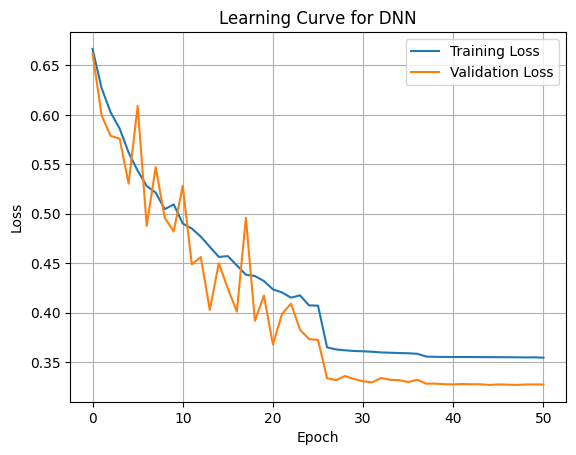

In [37]:
# Assuming history is a Keras training history object
plt.plot(train_history.history['loss'], label='Training Loss')
plt.plot(train_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN')
plt.legend()
plt.grid(True)
plt.show()

Let's see the confusion matrix

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
y_pred = model.predict(X_test)
y_pred_classified = np.argmax(y_pred, axis=1)

1233/1233 [==============================] - 3s 2ms/step


In [40]:
conf_mx = confusion_matrix(y_test, y_pred_classified)
conf_mx

array([[ 320,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  17,  216,    0,    0,    0,    0,    0,    0,   13,    0,    0,
           0,    0,    0,    0],
       [ 171,   63, 2313,    0,    0,    0,    0,    0,   74,    0,    0,
           0,    0,    0,    0],
       [   3,    0,    6, 1578,    0,  128,    0,    4,    0,    0,    3,
         773,   49,    0,    0],
       [   2,    0,    0,    0, 2310,  231,    0,   49,    0,    0,    0,
           0,    0,    0,    0],
       [   0,    0,    0,   93,  320, 1832,    0,  172,    0,   20,    0,
         201,    0,    0,    0],
       [   0,    0,    0,    0,    1,    5, 2297,    0,  177,    0,    0,
           3,    0,    0,    0],
       [   1,    0,    0,  100,  617,  339,    0, 1176,    0,  133,    0,
         157,    0,    0,    0],
       [  97,   84,    0,    0,    0,    0,    0,    0, 2417,    0,    0,
           0,    0,    0,    0],
       [   2,    0,    0,    1,    2,

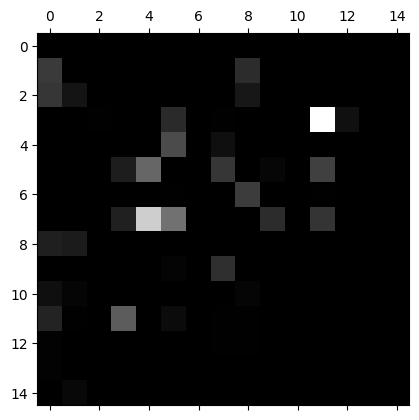

In [41]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [42]:
y_train.value_counts()

Attack_type
12    13549
13     8143
14     8007
2      6202
5      5959
3      5844
6      5817
4      5808
10     5804
8      5635
9      5627
11     5600
7      5545
0       669
1       553
Name: count, dtype: int64

The two confused classes (7 and 3) are not under-represeted and also we claculated the class's weights, so to improve that maybe we need to add features that will help differentiate between them

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [44]:
# Macro-averaged metrics
precision = precision_score(y_test, y_pred_classified, average='macro')
recall = recall_score(y_test, y_pred_classified, average='macro')
f1 = f1_score(y_test, y_pred_classified, average='macro')

# Hamming loss
from sklearn.metrics import hamming_loss
hamming_loss_value = hamming_loss(y_test, y_pred_classified)

print("Averaged Precision:", precision)
print("Averaged Recall:", recall)
print("Averaged F1-score:", f1)
print("Hamming Loss:", hamming_loss_value)

Averaged Precision: 0.8212466852399433
Averaged Recall: 0.8664406922140374
Averaged F1-score: 0.8275244689955147
Hamming Loss: 0.12390367553865653


Overall, this model performs worse than the trained RF model